# Examining the Homeless Population of the United States
By Andrew Watkins

## Machine Learning

In [1]:
#Data Wrangling from previous section
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Name the files to use
file_hic_state = 'data/2007-2017-HIC-Counts-by-State.xlsx'
file_pit_state = 'data/2007-2017-PIT-Counts-by-State.xlsx'

# Load spreadsheet
hic_state = pd.ExcelFile(file_hic_state)
pit_state = pd.ExcelFile(file_pit_state)

#HIC
df_hic = pd.DataFrame()

#concat the rest of the sheets to the original df
for sheet in range(2007, 2018): 
    excel_sheet = hic_state.parse(str(sheet), header=1)
    excel_sheet['year'] = str(sheet)
    excel_sheet.set_index(['year','State'], inplace=True)
    df_hic = pd.concat([df_hic, excel_sheet], axis=0, ignore_index=False, sort=True)
    
#Columns were named differenlty before 2014 so we will use all the named variations and then combine them.
columns_to_use = [ "Total Year-Round Beds (ES)",
                   "Total Year-Round ES Beds",
                   "Total Year-Round Beds (TH)",
                   "Total Year-Round TH Beds",
                   "Total Year-Round Beds (SH)",
                   "Total Year-Round SH Beds",
                   "Total Year-Round Beds (PSH)",
                   "Total Year-Round PSH Beds",
                   "Total Year-Round Beds (RRH)",
                   "Total Year-Round RRH Beds",
                   "Total Year-Round Beds (DEM)",
                   "Total Year-Round Beds (OPH)",
]
df_hic = df_hic[columns_to_use]
df_hic.fillna(0.0, inplace=True)


#Here we combine the coumns that contain the same informaiton but were named differently. 
df_hic['Total Year-Round Beds (ES)'] = df_hic['Total Year-Round Beds (ES)'] + df_hic['Total Year-Round ES Beds']
df_hic['Total Year-Round Beds (TH)'] = df_hic['Total Year-Round Beds (TH)'] + df_hic['Total Year-Round TH Beds']
df_hic['Total Year-Round Beds (SH)'] = df_hic['Total Year-Round Beds (SH)'] + df_hic['Total Year-Round SH Beds']
df_hic['Total Year-Round Beds (PSH)'] = df_hic['Total Year-Round Beds (PSH)'] + df_hic['Total Year-Round PSH Beds']
df_hic['Total Year-Round Beds (RRH)'] = df_hic['Total Year-Round Beds (RRH)'] + df_hic['Total Year-Round RRH Beds']

#We drop the extra columns we no longer need.
cols_to_drop = ['Total Year-Round ES Beds',
                'Total Year-Round TH Beds',
                'Total Year-Round SH Beds',
                'Total Year-Round PSH Beds',
                'Total Year-Round RRH Beds']
df_hic.drop(cols_to_drop, axis=1, inplace=True)

#PIT
#Create a new DF with the rest of the sheets. Which are the homeless population in each state from 2007-2017
df_pit = pd.DataFrame()

#concat the rest of the sheets to the original df
for sheet in range(2007, 2018):
    excel_sheet = pit_state.parse(str(sheet))
    excel_sheet['year'] = str(sheet)
    excel_sheet.set_index(['year','State'], inplace=True)
    #rename the columns
    cols_to_use = []
    for column in excel_sheet.columns:
        if column.__contains__(','):
            cols_to_use.append(column.split(',')[0])
        else:
            cols_to_use.append(column)
    excel_sheet.columns = cols_to_use
    df_pit = pd.concat([df_pit, excel_sheet], axis=0, ignore_index=False, sort=True)
    
#There are only two with the note. So we just drop them directly. 
df_pit.drop(level=1, inplace=True, index='Note: The number of CoCs in 2016 was 402. However, MO-604 merged in 2016 and covers territory in both MO and KS, contributing to the PIT count in both states. ')
df_pit.drop(level=1, inplace=True, index='Note: The number of CoCs in 2017 was 399. However, MO-604 merged in 2016 and covers territory in both MO and KS, contributing to the PIT count in both states. ')

#Grab the 2 columns that we need for now
df_pit = df_pit[['Total Homeless', 'Number of CoCs']]
df_pit.fillna(0, inplace=True)
df_pit.replace(to_replace='.', value='0', inplace=True)
df_pit = df_pit.astype(float, copy=False)

#Merge both DF (PIT and HIC) and drop some unecessary columns
df = pd.concat([df_hic, df_pit], axis=1)
df.drop(index=['Total', ' ', 'MP'], level=1, inplace=True)

#in 2015 there is a KS with an * that we need to fix
df.reset_index(inplace=True)
df = df.replace({'State': {'KS*':'KS'}}).groupby(['year','State'], sort=False).sum()

#Create an aggregate column of the total of all the beds.
df['Total Beds'] = df_hic['Total Year-Round Beds (ES)'] + df_hic['Total Year-Round Beds (TH)'] + df_hic['Total Year-Round Beds (SH)'] + df_hic['Total Year-Round Beds (PSH)'] + df_hic['Total Year-Round Beds (RRH)'] + df_hic['Total Year-Round Beds (DEM)'] + df_hic['Total Year-Round Beds (OPH)']

#Add a column of change to date 
df['Change to date'] = (df['Total Homeless'] - df.loc['2007','Total Homeless']) / (df.loc['2007','Total Homeless'])

#get the length of states and crate an empty list
length = len(df.loc['2007'])
last_year_changes = list()

#pad the list with zeros as 2007 has no population change.
for state in df.loc['2007','Total Homeless']:
    last_year_changes.append(0)

#loop through the years and calculate the population percentage change 
for year in range(2008, 2018):
    listy = pd.Series.tolist((df.loc[str(year), 'Total Homeless'] - df.loc[str(year-1),'Total Homeless']) / (df.loc[str(year-1),'Total Homeless']))
    last_year_changes = last_year_changes + listy

#add the list of changes to the dataframe
df['Change from last year'] = last_year_changes

#add 'homeless w/o beds'
df['Homeless w/o beds'] = df['Total Homeless'] - df['Total Beds']

#add the able column based on the 'Change to date' or 'Change from last year' columns
df['Able'] = (df['Change to date'].map(lambda x: x < 0.00)) & (df['Change from last year'].map(lambda x: x < 0.00))

ML Models
-Linear Regression
-Logistic Regression (How to divide/classify the total amount of beds?)
-Decision Tree
-SVM
-Naive Bayes
-K-Means
-Random Forests

# Section:  Linear Regression

In [2]:
#additional imports needed for ML
from sklearn.model_selection import train_test_split

In [3]:
#We now need to create a train-test split in our data that we will use on all our models.
X=df['Total Homeless'].values.reshape(-1,1)
y=df['Total Beds'].values.reshape(-1,1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [4]:
#drop CA and NY
df_min = df.drop(index=['CA', 'NY'], level=1)

#We now need to create a train-test split in our data that we will use on all our models.
X_min=df_min['Total Homeless'].values.reshape(-1,1)
y_min=df_min['Total Beds'].values.reshape(-1,1)

X_train_min, X_test_min, y_train_min, y_test_min = train_test_split(X_min, y_min, test_size = 0.2, random_state=42)

In [5]:
df_linear_scoring = pd.DataFrame()

## Linear Regression

In [6]:
from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error

In [7]:
#Create linear regression object
model = linear_model.LinearRegression()
    
# Train the model using the training sets and check score
model.fit(X_train, y_train)
    
#Predict Output
y_pred = model.predict(X_test)

# Compute R^2 and RMSE
r_square = model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#Add them to the scoring DF
scores = [r_square, rmse]
df_linear_scoring['Linear Regression'] = scores
df_linear_scoring.index = ['R square', 'RMSE'] #add  the indexes now

#Print R^2 and RMSE
print("R^2: ", r_square)
print("Root Mean Squared Error: ", rmse)

R^2:  0.8943233585662147
Root Mean Squared Error:  5202.40369865816


Now we will proceed to do the same models and check how they perform with when we remove the ouliers. 
 

In [8]:
# Create linear regression object
model = linear_model.LinearRegression()

# Train the model using the training sets and check score
model.fit(X_train_min, y_train_min)

#Predict Output
y_pred_min = model.predict(X_test_min)

# Compute R^2 and RMSE
r_square = model.score(X_test_min, y_test_min)
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))

#Add them to the scoring DF
scores = [r_square, rmse]
df_linear_scoring['Linear Regression Min'] = scores

#print R^2 and RMSE
print("R^2: ", r_square)
print("Root Mean Squared Error: ", rmse)

R^2:  0.6922340355400752
Root Mean Squared Error:  5247.726460915807


## Ordinary least squares (OLS)

In [9]:
from statsmodels.formula.api import ols
from patsy.builtins import *

In [10]:
model = ols("Q('Total Homeless') ~ Q('Total Beds')", df).fit()

r_square = model.rsquared
rmse = 0 #cannot compute as the shapes are different

#Add them to the scoring DF
scores = [r_square, rmse]
df_linear_scoring['OLS'] = scores

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Q('Total Homeless')   R-squared:                       0.820
Model:                             OLS   Adj. R-squared:                  0.820
Method:                  Least Squares   F-statistic:                     2697.
Date:                 Sat, 06 Apr 2019   Prob (F-statistic):          1.36e-222
Time:                         13:57:42   Log-Likelihood:                -6211.7
No. Observations:                  594   AIC:                         1.243e+04
Df Residuals:                      592   BIC:                         1.244e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept       -1048.3932    41

In [11]:
model = ols("Q('Total Homeless') ~ Q('Total Beds')", df_min).fit()

r_square = model.rsquared
rmse = 0 #cannot compute as the shapes are different

#Add them to the scoring DF
scores = [r_square, rmse]
df_linear_scoring['OLS Min'] = scores

print(model.summary())

                             OLS Regression Results                            
Dep. Variable:     Q('Total Homeless')   R-squared:                       0.666
Model:                             OLS   Adj. R-squared:                  0.665
Method:                  Least Squares   F-statistic:                     1134.
Date:                 Sat, 06 Apr 2019   Prob (F-statistic):          1.13e-137
Time:                         13:57:42   Log-Likelihood:                -5678.3
No. Observations:                  572   AIC:                         1.136e+04
Df Residuals:                      570   BIC:                         1.137e+04
Df Model:                            1                                         
Covariance Type:             nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept         348.8013    30

## Decission Tree

In [12]:
#Import Library
from sklearn import tree
from sklearn.metrics import accuracy_score

In [13]:
# Create tree object 
model = tree.DecisionTreeRegressor() #for regression

#Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred= model.predict(X_test)

# Compute R^2 and RMSE
r_square = model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#Add them to the scoring DF
scores = [r_square, rmse]
df_linear_scoring['Decission Tree'] = scores

#Print R^2 and RMSE
print("R^2: ", r_square)
print("Root Mean Squared Error: ", rmse)

R^2:  0.7557748670573805
Root Mean Squared Error:  7908.784208559684


In [14]:
# Create tree object 
model = tree.DecisionTreeRegressor()

#Train the model using the training sets and check score
model.fit(X_train_min, y_train_min)

#Predict Output
y_pred_min = model.predict(X_test_min)

# Compute R^2 and RMSE
r_square = model.score(X_test_min, y_test_min)
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))

#Add them to the scoring DF
scores = [r_square, rmse]
df_linear_scoring['Decission Tree Min'] = scores

#print R^2 and RMSE
print("R^2: ", r_square)
print("Root Mean Squared Error: ", rmse)

R^2:  0.5423021831180048
Root Mean Squared Error:  6399.562940239509


## KNN

In [15]:
#Import Library
from sklearn.neighbors import KNeighborsClassifier

In [16]:
# Create KNeighbors classifier object model 
model = KNeighborsClassifier(n_neighbors=6) # default value for n_neighbors is 5

# Train the model using the training sets and check score
model.fit(X_train, y_train.ravel())

#Predict Output
y_pred = model.predict(X_test)

# Compute R^2 and RMSE
r_square = model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#Add them to the scoring DF
scores = [r_square, rmse]
df_linear_scoring['KNN'] = scores

#Print R^2 and RMSE
print("R^2: ", r_square)
print("Root Mean Squared Error: ", rmse)

R^2:  0.0
Root Mean Squared Error:  7861.49840903718


In [17]:
# Create KNeighbors classifier object model 
model = KNeighborsClassifier(n_neighbors=6) # default value for n_neighbors is 5

# Train the model using the training sets and check score
model.fit(X_train_min, y_train_min.ravel())

#Predict Output
y_pred = model.predict(X_test_min)

# Compute R^2 and RMSE
r_square = model.score(X_test_min, y_test_min)
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))

#Add them to the scoring DF
scores = [r_square, rmse]
df_linear_scoring['KNN Min'] = scores

#print R^2 and RMSE
print("R^2: ", r_square)
print("Root Mean Squared Error: ", rmse)

R^2:  0.0
Root Mean Squared Error:  6399.562940239509


## Random Forest

In [18]:
#Import Library
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
from sklearn.ensemble import RandomForestClassifier

In [19]:
# Create Random Forest object
model = RandomForestClassifier()

# Train the model using the training sets and check score
model.fit(X_train, y_train.ravel())

#Predict Output
y_pred = model.predict(X_test)

# Compute R^2 and RMSE
r_square = model.score(X_test, y_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

#Add them to the scoring DF
scores = [r_square, rmse]
df_linear_scoring['Random Forest'] = scores

#Print R^2 and RMSE
print("R^2: ", r_square)
print("Root Mean Squared Error: ", rmse)

R^2:  0.0
Root Mean Squared Error:  7857.630385103868


In [20]:
# Create Random Forest object
model = RandomForestClassifier()

# Train the model using the training sets and check score
model.fit(X_train_min, y_train_min.ravel())

#Predict Output
y_pred = model.predict(X_test_min)

# Compute R^2 and RMSE
r_square = model.score(X_test_min, y_test_min)
rmse = np.sqrt(mean_squared_error(y_test_min, y_pred_min))

#Add them to the scoring DF
scores = [r_square, rmse]
df_linear_scoring['Random Forest Min'] = scores

#print R^2 and RMSE
print("R^2: ", r_square)
print("Root Mean Squared Error: ", rmse)

R^2:  0.008695652173913044
Root Mean Squared Error:  6399.562940239509


In [21]:
df_linear_scoring.head()

,Linear Regression,Linear Regression Min,OLS,OLS Min,Decission Tree,Decission Tree Min,KNN,KNN Min,Random Forest,Random Forest Min
R square,0.894323,0.692234,0.819979,0.665533,0.755775,0.542302,0.000000,0.00000,0.000000,0.008696
RMSE,5202.403699,5247.726461,0.000000,0.000000,7908.784209,6399.562940,7861.498409,6399.56294,7857.630385,6399.562940


# Section: Logistic Regression

In this section we will use logistic regression to classify the states. We are going to use a threshold we have determined earlier. The threshold we are going to use is called 'Able', it is a column which indicates True is the state has reduced its homeless population from 2007 and the homeless population has also decressed in the past year.

In [22]:
#We now need to create a train-test split in our data that we will use on all our models.
y=df['Able'].values
X=df.drop('Able', axis=1).values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42)

In [23]:
#Create a df to store the scoring.
df_logistic_scoring = pd.DataFrame()

## Logistic Regression

In [24]:
#Import Library
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [25]:
# Create logistic regression object
model = LogisticRegression()

# Train the model using the training sets and check score
model.fit(X_train, y_train.ravel())

#Predict Output
y_pred = model.predict(X_test)

In [26]:
#Print Accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy: ', accuracy)

#Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

#Compute and print AUC score
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: ', auc)

#Print list of AUC scores
cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print('AUC scores computed using 5-fold cross-validation: ', cv_auc)

#Compute and print confusion report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', conf_matrix)

#Compute and print classification report
class_report = classification_report(y_test, y_pred)
print('Calssification Refort: \n', class_report)

scores = [accuracy, auc, cv_auc, conf_matrix]
df_logistic_scoring['Logistic Regression'] = scores
df_logistic_scoring.index = ['Accuracy', 'AUC', 'AUC cross val', 'Confusion Matrix']

Accuracy:  0.7478991596638656
AUC:  0.8573749187784275
AUC scores computed using 5-fold cross-validation:  [0.89852008 0.93023256 0.91829865 0.91541353 0.91165414]
Confusion Matrix: 
 [[74  7]
 [23 15]]
Calssification Refort: 
              precision    recall  f1-score   support

      False       0.76      0.91      0.83        81
       True       0.68      0.39      0.50        38

avg / total       0.74      0.75      0.73       119



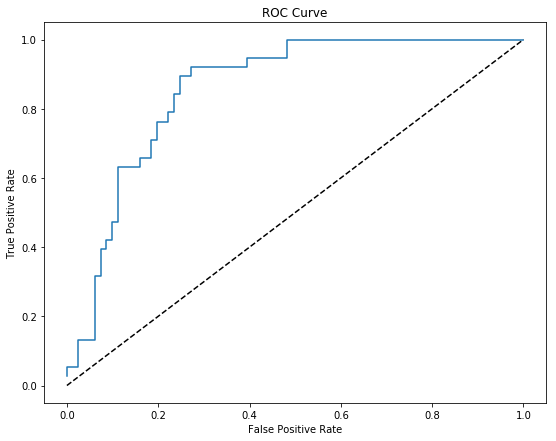

In [27]:
# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(9,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## KNN

In [28]:
#Import Library
from sklearn.neighbors import KNeighborsClassifier
from sklearn import model_selection

In [29]:
# Create KNeighbors classifier object model 
model = KNeighborsClassifier(n_neighbors=6) # default value for n_neighbors is 5

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred = model.predict(X_test)

In [30]:
#Print Accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy: ', accuracy)

#Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

#Compute and print AUC score
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: ', auc)

#Print list of AUC scores
cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print('AUC scores computed using 5-fold cross-validation: ', cv_auc)

#Compute and print confusion report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', conf_matrix)

#Compute and print classification report
class_report = classification_report(y_test, y_pred)
print('Calssification Refort: \n', class_report)

scores = [accuracy, auc, cv_auc, conf_matrix]
df_logistic_scoring['KNN'] = scores

Accuracy:  0.6218487394957983
AUC:  0.6481481481481481
AUC scores computed using 5-fold cross-validation:  [0.55028692 0.79926561 0.70639535 0.75626566 0.6231203 ]
Confusion Matrix: 
 [[66 15]
 [30  8]]
Calssification Refort: 
              precision    recall  f1-score   support

      False       0.69      0.81      0.75        81
       True       0.35      0.21      0.26        38

avg / total       0.58      0.62      0.59       119



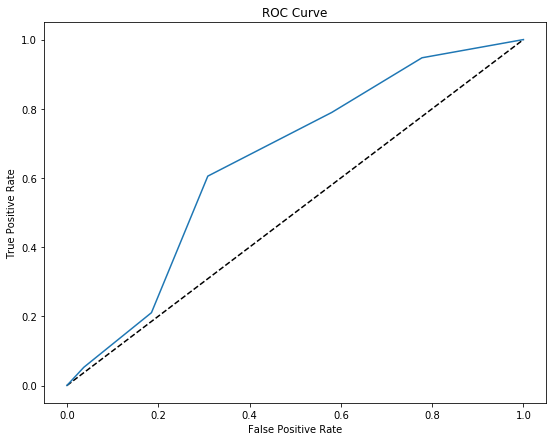

In [31]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(9,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## K-Means

In [32]:
#Import Library
from sklearn.cluster import KMeans

In [33]:
# Create KNeighbors classifier object model 
model = KMeans(n_clusters=1)

# Train the model using the training sets and check score
model.fit(X_train)

#Predict Output
y_pred = model.predict(X_test)

In [34]:
#Print Accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy: ', accuracy)

#Compute and print confusion report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', conf_matrix)

#Compute and print classification report
class_report = classification_report(y_test, y_pred)
print('Calssification Refort: \n', class_report)

scores = [accuracy, 0, 0, conf_matrix]
df_logistic_scoring['K-Means'] = scores

Accuracy:  0.680672268907563
Confusion Matrix: 
 [[81  0]
 [38  0]]
Calssification Refort: 
              precision    recall  f1-score   support

      False       0.68      1.00      0.81        81
       True       0.00      0.00      0.00        38

avg / total       0.46      0.68      0.55       119



C:\Users\andre\Anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


## Descision Tree

In [35]:
# Create tree object 
model = tree.DecisionTreeClassifier()

#Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred= model.predict(X_test)

In [36]:
#Print Accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy: ', accuracy)

#Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

#Compute and print AUC score
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: ', auc)

#Print list of AUC scores
cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print('AUC scores computed using 5-fold cross-validation: ', cv_auc)

#Compute and print confusion report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', conf_matrix)

#Compute and print classification report
class_report = classification_report(y_test, y_pred)
print('Calssification Refort: \n', class_report)

scores = [accuracy, auc, cv_auc, conf_matrix]
df_logistic_scoring['Descision Tree'] = scores

Accuracy:  1.0
AUC:  1.0
AUC scores computed using 5-fold cross-validation:  [0.95348837 1.         1.         1.         1.        ]
Confusion Matrix: 
 [[81  0]
 [ 0 38]]
Calssification Refort: 
              precision    recall  f1-score   support

      False       1.00      1.00      1.00        81
       True       1.00      1.00      1.00        38

avg / total       1.00      1.00      1.00       119



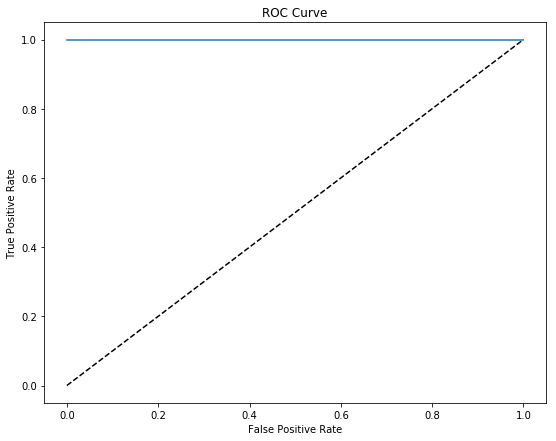

In [37]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(9,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## SVM

In [38]:
#Import Library
from sklearn import svm

In [39]:
# Create SVM classification object 
model = svm.SVC()

model.probability=True

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
predicted= model.predict(X_test)

In [40]:
#Print Accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy: ', accuracy)

#Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

#Compute and print AUC score
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: ', auc)

#Print list of AUC scores
cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print('AUC scores computed using 5-fold cross-validation: ', cv_auc)

#Compute and print confusion report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', conf_matrix)

#Compute and print classification report
class_report = classification_report(y_test, y_pred)
print('Calssification Refort: \n', class_report)

scores = [accuracy, auc, cv_auc, conf_matrix]
df_logistic_scoring['SVM'] = scores

Accuracy:  1.0
AUC:  0.4868421052631579
AUC scores computed using 5-fold cross-validation:  [0.5 0.5 0.5 0.5 0.5]
Confusion Matrix: 
 [[81  0]
 [ 0 38]]
Calssification Refort: 
              precision    recall  f1-score   support

      False       1.00      1.00      1.00        81
       True       1.00      1.00      1.00        38

avg / total       1.00      1.00      1.00       119



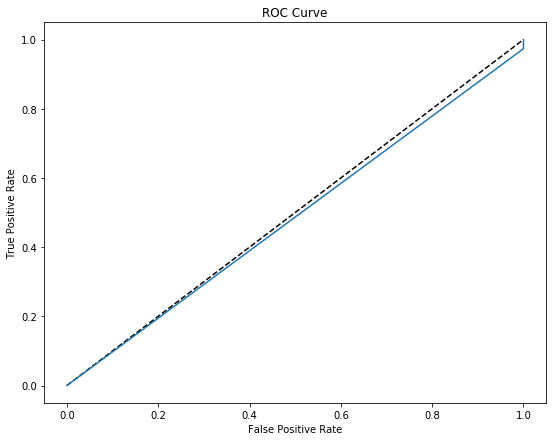

In [41]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(9,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Naive Bayes

In [42]:
#Import Library
from sklearn.naive_bayes import GaussianNB

In [43]:
# Create SVM classification object 
model = GaussianNB()

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred= model.predict(X_test)

In [44]:
#Print Accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy: ', accuracy)

#Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

#Compute and print AUC score
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: ', auc)

#Print list of AUC scores
cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print('AUC scores computed using 5-fold cross-validation: ', cv_auc)

#Compute and print confusion report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', conf_matrix)

#Compute and print classification report
class_report = classification_report(y_test, y_pred)
print('Calssification Refort: \n', class_report)

scores = [accuracy, auc, cv_auc, conf_matrix]
df_logistic_scoring['Naive Bayes'] = scores

Accuracy:  0.6302521008403361
AUC:  0.6575698505523068
AUC scores computed using 5-fold cross-validation:  [0.61733615 0.68359853 0.73623011 0.76817043 0.71005639]
Confusion Matrix: 
 [[72  9]
 [35  3]]
Calssification Refort: 
              precision    recall  f1-score   support

      False       0.67      0.89      0.77        81
       True       0.25      0.08      0.12        38

avg / total       0.54      0.63      0.56       119



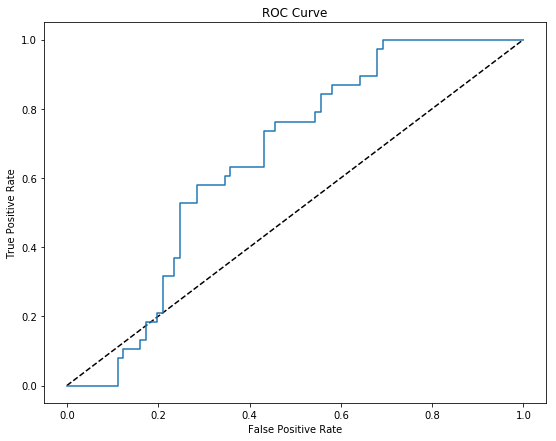

In [45]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(9,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

## Random Forest

In [46]:
# Create Random Forest object
model = RandomForestClassifier()

# Train the model using the training sets and check score
model.fit(X_train, y_train)

#Predict Output
y_pred = model.predict(X_test)

In [47]:
#Print Accuracy
accuracy = accuracy_score(y_pred, y_test)
print('Accuracy: ', accuracy)

#Compute predicted probabilities: y_pred_prob
y_pred_prob = model.predict_proba(X_test)[:,1]

#Compute and print AUC score
auc = roc_auc_score(y_test, y_pred_prob)
print('AUC: ', auc)

#Print list of AUC scores
cv_auc = cross_val_score(model, X, y, cv=5, scoring='roc_auc')
print('AUC scores computed using 5-fold cross-validation: ', cv_auc)

#Compute and print confusion report
conf_matrix = confusion_matrix(y_test, y_pred)
print('Confusion Matrix: \n', conf_matrix)

#Compute and print classification report
class_report = classification_report(y_test, y_pred)
print('Calssification Refort: \n', class_report)

scores = [accuracy, auc, cv_auc, conf_matrix]
df_logistic_scoring['Random Forest'] = scores

Accuracy:  0.9831932773109243
AUC:  0.9996751137102015
AUC scores computed using 5-fold cross-validation:  [0.99546965 1.         0.999847   1.         1.        ]
Confusion Matrix: 
 [[81  0]
 [ 2 36]]
Calssification Refort: 
              precision    recall  f1-score   support

      False       0.98      1.00      0.99        81
       True       1.00      0.95      0.97        38

avg / total       0.98      0.98      0.98       119



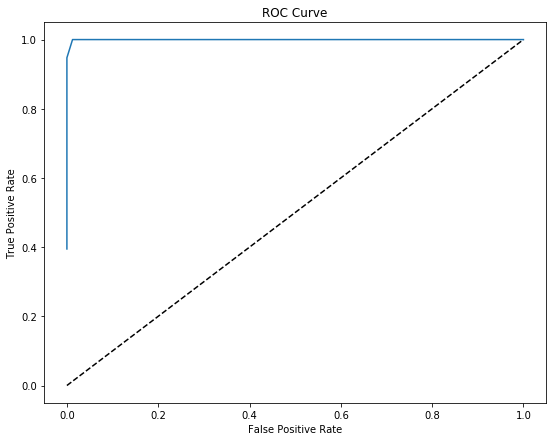

In [48]:
# Compute predicted probabilities
y_pred_prob = model.predict_proba(X_test)[:,1]

# Generate ROC curve values
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)

# Plot ROC curve
fig, ax = plt.subplots(figsize=(9,7))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.show()

In [49]:
df_logistic_scoring.head()

,Logistic Regression,KNN,K-Means,Descision Tree,SVM,Naive Bayes,Random Forest
Accuracy,0.747899,0.621849,0.680672,1,1,0.630252,0.983193
AUC,0.857375,0.648148,0,1,0.486842,0.65757,0.999675
AUC cross val,"[0.8985200845665963, 0.9302325581395349, 0.918...","[0.5502869223799456, 0.799265605875153, 0.7063...",0,"[0.9534883720930232, 1.0, 1.0, 1.0, 1.0]","[0.5, 0.5, 0.5, 0.5, 0.5]","[0.6173361522198731, 0.6835985312117503, 0.736...","[0.9954696466324373, 1.0, 0.9998470012239902, ..."
Confusion Matrix,"[[74, 7], [23, 15]]","[[66, 15], [30, 8]]","[[81, 0], [38, 0]]","[[81, 0], [0, 38]]","[[81, 0], [0, 38]]","[[72, 9], [35, 3]]","[[81, 0], [2, 36]]"


In [50]:
#a reminder of how the linear regression scores look like
df_linear_scoring.head()

,Linear Regression,Linear Regression Min,OLS,OLS Min,Decission Tree,Decission Tree Min,KNN,KNN Min,Random Forest,Random Forest Min
R square,0.894323,0.692234,0.819979,0.665533,0.755775,0.542302,0.000000,0.00000,0.000000,0.008696
RMSE,5202.403699,5247.726461,0.000000,0.000000,7908.784209,6399.562940,7861.498409,6399.56294,7857.630385,6399.562940


## Final Thoughts

In this section we applied both linear and logistic regression to our data. Lets first discuss what we did with our linear regression models. We used 5 different linear regression models on our data to try and predict beds based on the total homeless population. We also used two different datasets one with all the data and another with the ouliers removed. All the models that used the datasets without the outliers performed worse across the board against their counter parts. In addition we had some models that were horrible because they had a R^2 score of 0. The best performing model we had was a simple Linear Regression model with a score of 0.89 and the Ordinary Least Square as a close second with 0.82. These a pretty good models in predicting the ammount of beds a state would get/use to help with their homeless population.

In this section we will use logistic regression to classify the states. We are going to use a threshold we have determined earlier. The threshold we are going to use is called 'Able', it is a column which indicates True is the state has reduced its homeless population from 2007 and the homeless population has also decressed in the past year.

In this section we did not use the DataFrame without the outliers because we saw that is performed poorly acroos the board and we need all states to be able to classify them. We used 7 different logistic regression models on our data. Almost all our models performed really well, with the exception of K-Means which gave an accuracy score of 0.09 which is very low. Our best performin model is a simple Logistic Regression which gave a perfect score or 1 or 100%. This score at first was very odd but after chaking that all the data was used properly it does not seem to be a mistake. 